In [1]:
import numpy as np
import os
from os.path import join as pjoin

from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint

import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [2]:
from dataloader import section_loader_ts, F3_generator
from models import BUnetConvLSTM_Nto1
from metrics import mIoU
from utils import make_aug, PlotHistory

In [3]:
lossf = 'categorical_crossentropy'

bs = 1
_epochs = 100
verbose_train = 2
type_aug = "no_aug" #no_aug, aug1
f1 = 16

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Load Data

In [4]:
train_loader_i = section_loader_ts(direct = 'i', split = 'train')
train_loader_x = section_loader_ts(direct = 'x', split = 'train')
val_loader_i = section_loader_ts(direct = 'i',split = 'val')
val_loader_x = section_loader_ts(direct = 'x',split = 'val')

dat_tr1 = tf.data.Dataset.from_generator(train_loader_i.generator, output_types = (tf.float64, tf.float32), 
                                         output_shapes = ((5,688,256,1), (688,256,6)))
dat_tr2 = tf.data.Dataset.from_generator(train_loader_x.generator, output_types = (tf.float64, tf.float32),
                                        output_shapes = ((5,400,256,1), (400,256,6)))

dat_vl1 = tf.data.Dataset.from_generator(val_loader_i.generator, output_types = (tf.float64, tf.float32),
                                        output_shapes = ((5,688,256,1), (688,256,6)))
dat_vl2 = tf.data.Dataset.from_generator(val_loader_x.generator, output_types = (tf.float64, tf.float32),
                                        output_shapes = ((5,400,256,1), (400,256,6)))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [5]:
data_tr = [make_aug(dat_tr1, type_aug), make_aug(dat_tr2, type_aug)]
data_vl = [dat_vl1, dat_vl2]

num_train = len(train_loader_i) + len(train_loader_x)
num_val = len(val_loader_i) + len(val_loader_x)

In [6]:
train_gen = F3_generator(data_tr, bs)
val_gen = F3_generator(data_vl, bs)

### Modeling

In [7]:
model = BUnetConvLSTM_Nto1(n_classes=6, filters=32, ts=5)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, None, None, 1)  0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, None, None, 32) 320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, None, None, 32) 128       
_________________________________________________________________
activation_1 (Activation)    (None, 5, None, None, 32) 0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, None, None, 32) 9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, None, None, 32) 128       
_________________________________________________________________
acti

In [8]:
lr = 1e-3
lossf = 'categorical_crossentropy'

# opt = RMSprop(lr=lr)  
opt = Adam(lr=lr, amsgrad=False)

model.compile(optimizer=opt,
              loss = lossf,
              metrics=['acc', mIoU])

### Training

In [9]:
filepath = 'BUnetConvLSTM_' + str(f1) + '_' + type_aug + '_bn_ep100.h5'
stopPatience = 10

In [10]:
modelCheck = ModelCheckpoint(filepath,verbose=1, save_best_only=True, save_weights_only=True, period=1) # monitor="val_dice_loss", mode = 'min')
earlystopper = EarlyStopping(patience=stopPatience, verbose=1) # monitor="val_dice_loss", mode = 'min')
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=stopPatience//2, min_lr=0.0000005, verbose=1) # monitor="val_dice_loss", mode = 'min')
cb = [earlystopper,reduce_lr,modelCheck]

In [11]:


hs = model.fit_generator(train_gen,epochs=_epochs,
                    steps_per_epoch=num_train//bs,
                    callbacks=cb,
                    validation_data=val_gen, validation_steps=num_val//bs,
                    verbose = verbose_train, workers = 0)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
 - 72s - loss: 0.2186 - acc: 0.9525 - mIoU: 0.7301 - val_loss: 0.1654 - val_acc: 0.9592 - val_mIoU: 0.7359

Epoch 00001: val_loss improved from inf to 0.16536, saving model to BUnetConvLSTM_16_aug1_bn_ep100.h5
Epoch 2/100
 - 63s - loss: 0.1006 - acc: 0.9791 - mIoU: 0.8618 - val_loss: 0.0890 - val_acc: 0.9805 - val_mIoU: 0.8685

Epoch 00002: val_loss improved from 0.16536 to 0.08900, saving model to BUnetConvLSTM_16_aug1_bn_ep100.h5
Epoch 3/100
 - 63s - loss: 0.0796 - acc: 0.9819 - mIoU: 0.8898 - val_loss: 0.0679 - val_acc: 0.9845 - val_mIoU: 0.9109

Epoch 00003: val_loss improved from 0.08900 to 0.06794, saving model to BUnetConvLSTM_16_aug1_bn_ep100.h5
Epoch 4/100
 - 63s - loss: 0.0608 - acc: 0.9854 - mIoU: 0.9237 - val_loss: 0.0596 - val_acc: 0.9845 - val_mIoU: 0.9163

Epoch 00004: val_loss improved from 0.06794 to 0.05960, saving model to BUnetCon

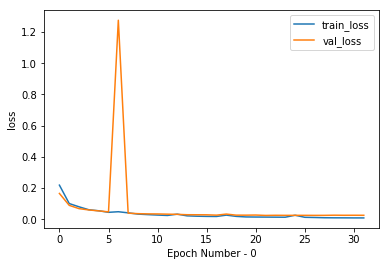

In [12]:
PlotHistory(hs, 'loss')

### Validation

In [13]:
import matplotlib.pyplot as plt

In [14]:
model.load_weights(filepath)

In [15]:
for batch in val_loader_i.generator():
    x1, y1 = batch
    print(x1.shape, y1.shape)
    
    break

(5, 688, 256, 1) (688, 256, 6)


In [16]:
y1_hat = model.predict(np.expand_dims(x1,axis=0))
y1_hat.shape

(1, 688, 256, 6)

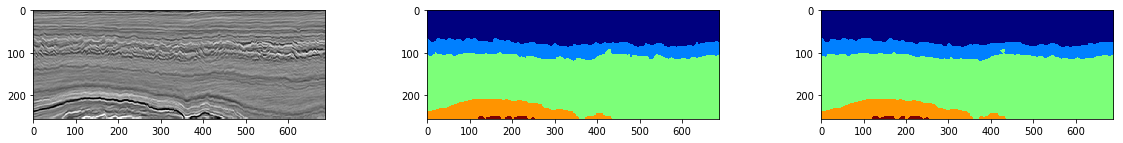

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,2))
axs[0].imshow(x1[-1,:,:,0].T, cmap='gray')
axs[1].imshow(np.argmax(y1,axis=-1).T, cmap='jet')
axs[2].imshow(np.argmax(y1_hat[0],axis=-1).T, cmap='jet')
plt.show()

### Testing

In [18]:
from dataloader import section_loader_test_ts
from utils import calculate_metrics_total

In [19]:
root = '/scratch/parceirosbr/maykol.trinidad/dataset/F3'
labels1  = np.load(pjoin(root,'test_once', 'test1_labels.npy' ))
labels2  = np.load(pjoin(root,'test_once', 'test2_labels.npy' ))

In [20]:
model.load_weights(filepath)

In [21]:
probs_predict1 = section_loader_test_ts(model, 'test1', get_prob=True)
probs_predict2 = section_loader_test_ts(model, 'test2', get_prob=True)

labels_predict1 = np.argmax(probs_predict1, axis=-1)
labels_predict2 = np.argmax(probs_predict2, axis=-1)

In [22]:
calculate_metrics_total(labels1, labels_predict1, labels2, labels_predict2)

Accuracy 1:  0.8943
Accuracy 2:  0.9283
Pixel Accuracy:  0.91
Class Accuracy:  [0.574 0.603 0.81  0.968 0.899 0.979]
Mean Class Accuracy:  0.8055
FWIOU:  0.8392
mIoU:  0.7102404589800942


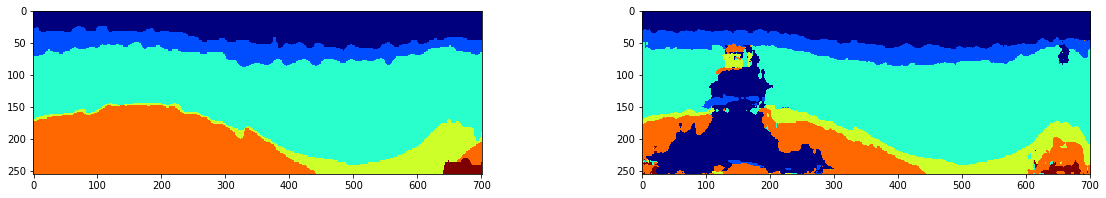

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,3))
axs[0].imshow(labels1[0].T, cmap='jet')
axs[1].imshow(labels_predict1[0].T, cmap='jet')
plt.show()